In [1]:
import pandas as pd
from exploratory_data_analysis import *
from stability_evaluation import *
from ks_evaluation import *
from model_fitting import *
from ranking_evaluation import *
import logistic_regression as py_lr
import weight_of_evidence as py_woe

from feature_select import *
from feature_process import *
from model_interpretion import *

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# 泰坦尼克数据集

In [2]:
df = pd.read_csv('test_data.csv')
df['group'] = df['Age'].apply(lambda x: 'seg1' if x < 40 else 'seg2')
print(df.shape)
df.head()

(891, 13)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,group
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,seg1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,seg1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,seg1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,seg1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,seg1


In [3]:
target = 'Survived'
k_col  = 'PassengerId'
c_cols = ['SibSp', 'Pclass', 'Age', 'Fare']
d_cols = ['Parch', 'SibSp', 'Pclass', 'Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']

In [4]:
from sklearn import linear_model
from scipy import stats

In [10]:
X = df[c_cols].fillna(0)
y = df[target]

In [14]:
lm = linear_model.LogisticRegression()
lm.fit(X, y)
params = np.append(lm.intercept_, lm.coef_)
predictions = lm.predict(X)

newX = pd.DataFrame({"Constant": np.ones(len(X))}).join(pd.DataFrame(X))
MSE = (sum((y - predictions) ** 2)) / (len(newX) - len(newX.columns))

# Note if you don't want to use a DataFrame replace the two lines above with
# newX = np.append(np.ones((len(X),1)), X, axis=1)
# MSE = (sum((y - predictions) ** 2)) / (len(newX) - len(newX[0]))

var_b = MSE * (np.linalg.inv(np.dot(newX.T, newX)).diagonal())
sd_b = np.sqrt(var_b)
ts_b = params / sd_b

p_values =[2 * (1 - stats.t.cdf(np.abs(i), (len(newX)-1))) for i in ts_b]

sd_b = np.round(sd_b, 3)
ts_b = np.round(ts_b, 3)
p_values = np.round(p_values, 3)
params = np.round(params, 4)

# 参数估计	标准误差	z值	wald卡方	p值	置信下界	置信上界

output_df = pd.DataFrame()
output_df["参数估计"], output_df["标准误差"], output_df["t values"], output_df["Probabilites"] = [params, sd_b, ts_b, p_values]
output_df


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


,Coefficients,Standard Errors,t values,Probabilites
0,1.3981,0.088,15.808,0.0
1,-0.1193,0.018,-6.786,0.0
2,-0.7345,0.029,-25.731,0.0
3,-0.0156,0.001,-13.665,0.0
4,0.0069,0.000,15.018,0.0


In [5]:
import xgboost as xgb
model = xgb.XGBClassifier()
fitted_model = model.fit(df[c_cols], df[target])
df['score'] = list(fitted_model.predict_proba(df[c_cols])[:,1])

In [7]:
import feature_selector as fs

In [9]:
fs1 = fs.FeatureSelector(data=df, labels=target)

In [10]:
fs1.base_features

['PassengerId',
 'Survived',
 'Pclass',
 'Name',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Ticket',
 'Fare',
 'Cabin',
 'Embarked',
 'group',
 'score']

In [26]:
fs1.identify_zero_importance?

In [10]:
varclus_df = var_cluster(input_df=df, n_clusters=3, var_list=None)
varclus_df

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


,var,cluster
0,Parch,0
1,Pclass,0
2,SibSp,0
3,Age,1
4,PassengerId,1
5,Survived,2
6,Fare,2
7,score,2


In [11]:
iv_df = iv_grouply_table(input_df=df, target_var=target, var_list=c_cols, group_var='group')
iv_df

,var,seg1,seg2,mean,std,cv,iv_rank,target
1,Fare,0.648085,0.571201,0.609643,0.054365,0.089029,1,Survived
0,Age,0.222415,0.265318,0.243866,0.030337,0.123892,2,Survived
3,SibSp,0.034552,0.000000,0.017276,0.024432,1.336832,3,Survived
2,Pclass,0.000000,0.000000,0.000000,0.000000,0.000000,4,Survived


In [8]:
import_df = feat_importance(model=fitted_model, feat_list=c_cols, accumulate_score=0.95)
import_df

累积score达到0.95时的特征序号为4


,var,score,score_rank,top
0,Age,0.436644,1,
1,Fare,0.416096,2,
2,SibSp,0.090753,3,
3,Pclass,0.056507,4,<<<


In [12]:
shap_df = shap_value(trained_model=fitted_model, X_train=df[c_cols], var_list=c_cols)
shap_df

,var,shap_value
0,SibSp,4.380519
1,Pclass,9.648493
2,Age,4.860779
3,Fare,-90.666223


In [13]:
merge_feature_index(var_cluster_df=varclus_df, 
                    iv_df=iv_df, 
                    importance_df=import_df,
                    shap_df=shap_df)

,var,cluster,iv,iv_rank,tree_import,tree_import_rank,shap_value
0,Parch,0,NaN,NaN,NaN,NaN,NaN
1,Pclass,0,0.000000,4.0,0.056507,4.0,9.648493
2,SibSp,0,0.017276,3.0,0.090753,3.0,4.380519
3,Age,1,0.243866,2.0,0.436644,1.0,4.860779
4,PassengerId,1,NaN,NaN,NaN,NaN,NaN
5,Survived,2,NaN,NaN,NaN,NaN,NaN
6,Fare,2,0.609643,1.0,0.416096,2.0,-90.666223
7,score,2,NaN,NaN,NaN,NaN,NaN


In [14]:
train_model?

In [5]:
trained_model = train_model(model=model, 
                     X_train=df[c_cols].fillna(999999), 
                     y_train=df[target])

模型开始训练中...
Running time: 0.0006371 Minutes
输出模型训练结果...
KS Value  (INS): 0.5412
Accuracy  (INS): 0.7722
AUC Score (INS): 0.854296
--------------------


In [6]:
x1, x2 = test_model(trained_model, df[c_cols].fillna(999999), df[target])

开始模型预测...
KS Value  (OOT): 0.5412
Accuracy  (OOT): 0.7722
AUC Score (OOT): 0.854296
--------------------


In [7]:
output_df = feat_importance(model=trained_model, feat_list=c_cols, accumulate_score=0.95)
output_df

[0.4267857, 0.35892856, 0.09821428, 0.060714286, 0.055357143]
累积score达到0.95时的特征序号为4


,var,score,top
0,Fare,0.426786,
1,Age,0.358929,
2,SibSp,0.098214,
3,Pclass,0.060714,
4,Parch,0.055357,<<<


In [16]:
WoE._help?

In [32]:
edd1 = edd_for_continue_var(input_df=df, group_var='group')
edd1

100%|██████████| 2/2 [00:00<00:00, 20.21it/s]


,group,total,cover_cnt,cover_rate,mean,std,min,25%,50%,75%,max
Age,seg1,551,551,1.000000,23.639147,9.572505,0.420000,18.000000,24.000000,31.000000,39.000000
Age,seg2,340,163,0.479412,50.184049,8.397523,40.000000,44.000000,48.000000,55.000000,80.000000
Fare,seg1,551,551,1.000000,32.592944,54.552241,0.000000,7.925000,13.000000,30.035400,512.329200
Fare,seg2,340,340,1.000000,31.574228,40.673160,0.000000,7.891650,15.245800,34.109350,263.000000
Parch,seg1,551,551,1.000000,0.444646,0.824689,0.000000,0.000000,0.000000,1.000000,5.000000
Parch,seg2,340,340,1.000000,0.279412,0.765125,0.000000,0.000000,0.000000,0.000000,6.000000
PassengerId,seg1,551,551,1.000000,446.223230,262.668182,1.000000,218.000000,436.000000,683.500000,891.000000
PassengerId,seg2,340,340,1.000000,445.638235,248.882473,6.000000,236.750000,459.500000,649.500000,889.000000
Pclass,seg1,551,551,1.000000,2.372051,0.784775,1.000000,2.000000,3.000000,3.000000,3.000000
Pclass,seg2,340,340,1.000000,2.205882,0.904900,1.000000,1.000000,3.000000,3.000000,3.000000


In [9]:
cv_grouply_table(edd_table=edd1, eval_index='mean')

,seg1,seg2,mean,std,cv,eval_index
PassengerId,446.223230,445.638235,445.930733,0.413654,0.000928,mean
Fare,32.592944,31.574228,32.083586,0.720341,0.022451,mean
Pclass,2.372051,2.205882,2.288967,0.117499,0.051310,mean
Survived,0.415608,0.332353,0.373980,0.058870,0.156995,mean
SibSp,0.568058,0.450000,0.509029,0.083480,0.163676,mean
score,0.417455,0.330026,0.373741,0.061822,0.164972,mean
Parch,0.444646,0.279412,0.362029,0.116838,0.321843,mean
Age,23.639147,50.184049,36.911598,18.770080,0.508501,mean


In [10]:
edd2 = edd_for_discrete_var(input_df=df, group_var='group')
edd2

100%|██████████| 2/2 [00:00<00:00,  3.04it/s]


,variable,value,total,cover_cnt,cover_rate,group
0,Name,"Abbing, Mr. Anthony",891,1,0.001122,seg1
1,Name,"Abbott, Mr. Rossmore Edward",891,1,0.001122,seg1
2,Name,"Abbott, Mrs. Stanton (Rosa Hunt)",891,1,0.001122,seg1
3,Name,"Abelson, Mr. Samuel",891,1,0.001122,seg1
4,Name,"Abelson, Mrs. Samuel (Hannah Wizosky)",891,1,0.001122,seg1
5,Name,"Adahl, Mr. Mauritz Nils Martin",891,1,0.001122,seg1
6,Name,"Adams, Mr. John",891,1,0.001122,seg1
7,Name,"Ahlin, Mrs. Johan (Johanna Persdotter Larsson)",891,1,0.001122,seg1
8,Name,"Aks, Mrs. Sam (Leah Rosen)",891,1,0.001122,seg1
9,Name,"Albimona, Mr. Nassef Cassem",891,1,0.001122,seg1


In [41]:
cv_grouply_table?

In [42]:
missing_rate_stat(input_df=df).head()

100%|██████████| 1/1 [00:00<00:00, 17.82it/s]


,all,mean,std,cv
Cabin,0.771044,0.771044,NaN,NaN
Age,0.198653,0.198653,NaN,NaN
Embarked,0.002245,0.002245,NaN,NaN
score,0.000000,0.000000,NaN,NaN
group,0.000000,0.000000,NaN,NaN


In [44]:
target_rate_stat(input_df=df, group_var='group', target_var_list=[target])

100%|██████████| 1/1 [00:00<00:00, 35.75it/s]


,group,total,effs,effs_rate,inters,goods,bads,odds,bad_rate,bad_def
0,seg1,551,551,1.0,0,322,229,0.711180,0.415608,Survived
1,seg2,340,340,1.0,0,227,113,0.497797,0.332353,Survived


In [45]:
# stat_df, np_df, regroup, bins = ChiMerge(df, 'Fare', target, confidence_value=3.841, bin=5, sample_ratio=None)
# bins

In [18]:
def compute_WOE_IV(df,col,target):
    """
    param df:DataFrame|包含feature和label
    param col:str|feature名称，col这列已经经过分箱
    param taget:str|label名称,0,1
    return 每箱的WOE(字典类型）和总的IV之和,注意考虑计算时候分子分母为零的溢出情况
    """
    import numpy as np
    
    total = df.groupby([col])[target].count() #计算col每个分组中的样本总数
    total = pd.DataFrame({'total': total})
    
    bad   = df.groupby([col])[target].sum()   #计算col每个分组中的目标取值为1的总数，关注的正样本
    bad   = pd.DataFrame({'bad': bad})
    
    regroup = total.merge(bad,left_index=True,right_index=True,how='left')
    regroup.reset_index(level=0,inplace=True)
    
    N = sum(regroup['total'])  #样本总数
    B = sum(regroup['bad'])    #正样本总数
    
    regroup['good'] = regroup['total'] - regroup['bad'] #计算col每个分组中的目标取值为0的总数，关注的负样本
    G = N - B #负样本总数
    
    regroup['bad_pcnt'] = regroup['bad'].map(lambda x: x*1.0/B)
    regroup['good_pcnt'] = regroup['good'].map(lambda x: x * 1.0 / G)
    
    regroup["WOE"] = regroup.apply(lambda x:np.log(x.good_pcnt*1.0/x.bad_pcnt),axis=1)
    
    WOE_dict = regroup[[col,"WOE"]].set_index(col).to_dict(orient="index")
    IV = regroup.apply(lambda x:(x.good_pcnt-x.bad_pcnt)*np.log(x.good_pcnt*1.0/x.bad_pcnt),axis = 1)
    
    IV = sum(IV)
    
    return {"WOE":WOE_dict,"IV":IV}

In [22]:
compute_WOE_IV(df=df,col='Sex',target=target)

{'WOE': {'female': {'WOE': -1.5298770033401874},
  'male': {'WOE': 0.9838327092415774}},
 'IV': 1.3416814135556492}

In [7]:
psi_for_continue_var(expected_array=df['score'][:400],
                     actual_array=df['score'][401:], 
                     bins=5, bucket_type='bins', detail=0)

0.0012135368342979208

In [10]:
psi_for_continue_var(expected_array=df['score'][:400],
                     actual_array=df['score'][401:], 
                     bins=5, bucket_type='quantiles', detail=0)

0.007927937554239492

In [8]:
psi_for_continue_var(expected_array=df['score'][:400],
                           actual_array=df['score'][401:], 
                           bins=5, bucket_type='bins', detail=1)

,score_range,expecteds,expected(%),actucals,actucal(%),ac - ex(%),ln(ac/ex),psi,max
0,"[0.021,0.2095]",120.0,30.00,152.0,31.02,1.02,0.033434,0.000341,
1,"(0.2095,0.398]",117.0,29.25,140.0,28.57,-0.68,-0.023522,0.000159,
2,"(0.398,0.5865]",81.0,20.25,94.0,19.18,-1.07,-0.054284,0.000577,<<<<<<<
3,"(0.5865,0.7751]",44.0,11.00,55.0,11.22,0.22,0.019801,0.000045,
4,"(0.7751,0.9636]",38.0,9.50,48.0,9.80,0.30,0.031087,0.000091,
5,>>> summary,400.0,100.00,489.0,100.00,NaN,NaN,0.001214,<<< result


In [10]:
psi_t1 = psi_grouply_table(input_df=df, group_var='group', benchmark_list=['seg1'], 
                  compare_list=['seg1', 'seg2'], c_var_list=['Age', 'Fare', 'score', 'Cabin'])
psi_t1

,seg1,seg2,mean,max,benchmark
Fare,0,0.0349,0.0174,0.0349,seg1
score,0,0.3857,0.1928,0.3857,seg1
Age,0,4.7407,2.3704,4.7407,seg1


In [12]:
# -*- coding:utf-8 -*-
__author__ = 'fenghaijie / hjfeng0630@qq.com'

import pandas as pd
import numpy as np

def iv_grouply_table(input_df, target_var, var_list, 
                     group_var=None, group_list=None, 
                     bin_num=5, bin_list=None,
                     detail=False, save_file_path=None):
    """
    ----------------------------------------------------------------------
    功能：信息量分组计算
    ----------------------------------------------------------------------
    :param input_df: pd.DataFrame, 输入数据
    :param target_var: str, 目标变量
    :param var_list: list, 需要计算IV的变量列表
    :param group_var: string, 分组依据，如按[组，月，周]。默认值=None, 对整个数据集统计。示例: 'apply_month'
    :param group_list: list, 分组元素取值, 若为None，则默认为所有取值。示例: [201701, 201702]
    :param bin_num: int, 分箱数。默认值=5.
    :param bin_list: list, 分箱边界。例如[1, 2, 3]，则代表分为2个分箱[1, 2)和[2, 3）。默认为None
    :param detail: bool, 是否显示IV计算过程各分箱明细. 默认值=False, 不显示。
    :param save_file_path: string, csv文件保存路径. 默认值=None
    ----------------------------------------------------------------------
    :return output_df: 变量iv值
    ----------------------------------------------------------------------
    示例：
    >>> iv_grouply_table(input_df=raw_data[raw_data['user_gaopao_180d'] == 1], 
                         target_var='flag1', 
                         var_list=spec_feats,
                         group_var='apply_month', 
                         group_list=None, 
                         bin_num=5,
                         detail=0, save_file_path=None)
    >>> 
    	var	seg1	seg2	mean	std	cv	iv_rank	target
    1	Fare	0.648085	0.571201	0.609643	0.054365	0.089029	1	Survived
    0	Age	0.222415	0.265318	0.243866	0.030337	0.123892	2	Survived
    ------------
    >>> iv_grouply_table(input_df=raw_data[raw_data['user_gaopao_180d'] == 1], 
                         target_var='flag1', 
                         var_list=spec_feats,
                         group_var='apply_month', 
                         group_list=None, 
                         bin_num=5,
                         detail=1, save_file_path=None)
    >>>
    	apply_month	feature	labels	bins	min_score	max_score	obs	bad	good	bad_rate	good_rate	odds_good	woe	bin_iv	iv	target
    2018-01	app_platform_num_3m	0	-inf	-inf	3.000000	73	2	71	0.027397	0.972603	35.500000	1.088421	0.194885	1.122779	flag1
    2018-01	app_platform_num_3m	1	3.000000	3.000000	5.000000	63	0	63	0.000000	1.000000	inf	2.355170	0.564166	1.122779	flag1
    2018-01	app_platform_num_3m	2	5.000000	5.000000	7.000000	51	10	41	0.196078	0.803922	4.100000	-1.070125	0.319595	1.122779	flag1
    2018-01	app_platform_num_3m	3	7.000000	7.000000	10.000000	43	5	38	0.116279	0.883721	7.600000	-0.452963	0.037499	1.122779	flag1
    2018-01	app_platform_num_3m	4	10.000000	10.000000	inf	55	5	50	0.090909	0.909091	10.000000	-0.178526	0.006634	1.122779	flag1
    ----------------------------------------------------------------------
    """
    input_df_copy = input_df.copy()
    input_df_copy = input_df_copy.loc[(input_df_copy[target_var].isin([0,1])), :]

    if not isinstance(input_df_copy, pd.core.frame.DataFrame):
        raise Exception('参数input_df的格式错误，应为pandas.core.frame.DataFrame')

    cols = list(input_df_copy.columns)
    if group_var is not None:
        if group_var not in set(input_df_copy.columns):
            raise Exception('参数group_var取值包含不属于input_df的变量，请检查!')
        input_df_copy[group_var] = input_df_copy[group_var].apply(lambda x: str(x))
        input_df_copy['group'] = input_df_copy[group_var]
    else:
        group_var = 'group'
        input_df_copy[group_var] = 'all'
          
    if group_list is None: 
        group_list = sorted(list(set(input_df_copy[group_var])))
    else:
        group_list = sorted(list(set(group_list)))
    group_list = [str(x) for x in group_list]

    if var_list is not None:
        if not set(var_list).issubset(set(cols)):
            raise Exception('参数var_list取值包含不属于input_df的变量，请检查!')
        else:
            cols = var_list
    
    col_dtype = dict(input_df_copy.dtypes)
    def iv_calculate(x, y, bin_num, col_dtype, detail):
        """
        ----------------------------------------------------------------------
        功能：调用weight_of_evidence模块计算变量iv
        ----------------------------------------------------------------------
        :param x: pd.Series, 自变量取值列表
        :param y: pd.Series, 因变量取值列表
        :param col_dtype: dict, 自变量类型
        ----------------------------------------------------------------------
        :return iv: float, 信息量
        ----------------------------------------------------------------------
        """ 
        v_type = 'd' if col_dtype[x.name] == object else 'c'
        import weight_of_evidence as py_woe

        if bin_list is None:
            woe = py_woe.WoE(qnt_num=bin_num-1, min_block_size=2, v_type=v_type, t_type='b') 
        else:
            woe = py_woe.WoE(bins=bin_list, min_block_size=2, v_type=v_type, t_type='b')

        woe.fit(x, y)
        return woe.bins if detail else woe.iv
        
    """对各变量统计IV"""
    def iv_grouply_calculate(df_):
        iv_ = df_[var_list] \
                 .apply(iv_calculate, axis=0, args=(df_[target_var], bin_num, col_dtype, detail)) \
                 .reset_index()
        iv_.columns = ['var','iv']
        return iv_ 
    
    if detail:
        output_df = None
        for gp in group_list:
            gp_df = input_df_copy[input_df_copy[group_var] == gp]
            for var in var_list:
                woe_tmp = iv_calculate(x=gp_df[var], y=gp_df[target_var], bin_num=bin_num, col_dtype=col_dtype, detail=detail)
                woe_tmp[group_var] = str(gp)
                output_df = pd.concat([output_df, woe_tmp])
        
        output_df['target'] = target_var
        output_cols = [group_var, 'feature', 'labels', 'bins', 'min_score', 'max_score', 'obs', \
                       'bad', 'good', 'bad_rate', 'good_rate', 'odds_good', 'woe', 'bin_iv', 'iv', 'target']
        output_df = output_df[output_cols]
    else:
        if group_list is None: 
            stat_df = input_df_copy[cols] \
                                 .apply(iv_calculate, axis=0, args=(input_df_copy[target_var],  bin_num, col_dtype, detail)) \
                                 .reset_index()
            stat_df.columns = ['var','iv']
        else:
            stat_df = input_df_copy.groupby(group_var) \
                                 .apply(iv_grouply_calculate) \
                                 .reset_index(level=group_var)

        sort_value = ['group', 'iv'] if group_list is not None else ['iv']
        stat_df = stat_df.sort_values(by=['iv'], ascending=False)
        stat_df['group'] = stat_df[group_var]
        group_list = sorted(list(set(stat_df['group'])))
        
        output_df = pd.DataFrame(columns=['var'] + group_list)
        output_df['var'] = sorted(cols)
        for g in group_list:
            sub_stat_df = stat_df[stat_df['group'] == g]
            sub_stat_df = sub_stat_df.sort_values(by=['var'], ascending=1)
            output_df[str(g)] = list(sub_stat_df['iv'])
        output_df['mean'] = output_df.apply(lambda x: x[group_list].mean(), axis=1)
        output_df['std'] = output_df.apply(lambda x: x[group_list].std(), axis=1)
        output_df['temp'] = 0.001
        output_df['cv'] = output_df['std'] / (output_df['temp'] + output_df['mean'])
        output_df = output_df.sort_values(by=['mean'], ascending=0)
        output_df['iv_rank'] = [x for x in range(1, output_df.shape[0] + 1)]
        output_df = output_df.drop(['temp'], axis=1)
        output_df['target'] = target_var
    
    """文件保存"""
    if save_file_path:
        if not isinstance(save_file_path, str):
            raise Exception('参数save_file_path类型必须是str, 同时注意csv文件后缀!')
        elif save_file_path.endswith('.csv'):
            raise Exception('参数save_file_path不是csv文件后缀，请检查!')
        output_df.to_csv(save_file_path, encoding='utf-8', index=False)
        
    return output_df

In [15]:
iv_grouply_table(input_df=df, target_var='Survived', var_list=['score'], 
                     group_var='group', group_list=None, 
                     bin_num=5, bin_list=[0, 0.2, 0.3, 1],
                     detail=1, save_file_path=None)

,group,feature,labels,bins,min_score,max_score,obs,bad,good,bad_rate,good_rate,odds_good,woe,bin_iv,iv,target
0,seg1,score,1,0.0,0.0,0.200000,131,4,127,0.030534,0.969466,31.750000,3.117063,1.174954,1.547241,Survived
1,seg1,score,2,0.2,0.2,0.300000,87,26,61,0.298851,0.701149,2.346154,0.511948,0.038859,1.547241,Survived
2,seg1,score,3,0.3,0.3,inf,333,199,134,0.597598,0.402402,0.673367,-0.736295,0.333428,1.547241,Survived
0,seg2,score,1,0.0,0.0,0.200000,126,6,120,0.047619,0.952381,20.000000,2.298170,1.092865,1.674915,Survived
1,seg2,score,2,0.2,0.2,0.300000,25,3,22,0.120000,0.880000,7.333333,1.294868,0.091117,1.674915,Survived
2,seg2,score,3,0.3,0.3,inf,189,104,85,0.550265,0.449735,0.817308,-0.899302,0.490933,1.674915,Survived


In [27]:
def chi2_based_feature_select(input_df, var_list, target_var, top_k):
    '''
    功能：利用卡方检验选择top_k个最佳特征
    ----------------------------------------------------------------------
    :param input_df: pd.DataFrame，输入数据表
    :param var_list: list, 待筛选的特征列表
    :param target_var: str, 目标变量
    :param top_k: int, 最佳的k个变量
    ----------------------------------------------------------------------
    :return col: 筛选后的特征
    ----------------------------------------------------------------------
    示例:
    >>> chi2_based_feature_select
    >>>
    
    ----------------------------------------------------------------------
    '''
    from sklearn.feature_selection import SelectKBest
    from sklearn.feature_selection import chi2
    
    top_k = min(len(var_list), top_k)
    model = SelectKBest(chi2, k=top_k)
    model.fit_transform(input_df[var_list], input_df[target_var])
    
    chi2_df = pd.DataFrame(var_list, columns=['feature'])
    chi2_df['chi2_score'] = list(model.scores_)
    chi2_df = chi2_df.sort_values(by=['chi2_score'], ascending=0)
    
    selected_varlist = list(chi2_df['feature'].values)[:top_k]
    
    return selected_varlist

In [30]:
chi2_based_feature_select(input_df=df, var_list=c_cols, target_var=target, top_k=3)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
def IV_Cluster_FeatureSelect(iv_table, cluster_table):
    '''
    功能：先进行变量聚类，再从每个特征簇中保留iv最高的1个特征
    Args:      
       iv_table: df，包含['feature', 'iv']，由Var_Cluster()函数生成
       cluster_table: 包含['feature', 'cluster'], 由IV_Calculate()函数生成
    Returns:      
       col: 筛选后的特征
    '''
    cluster_df = pd.merge(cluster_table, iv_table, how='left', on='feature')
    cluster_df = cluster_df.sort_values(by=['cluster', 'IV'], ascending=[1, 0])
    col = []
    for c in sorted(list(set(cluster_df['cluster']))):
        cols = cluster_df[cluster_df['cluster'] == c]['feature'].values
        col.append(cols[0])
        
    return col


def IV_Correlation_FeatureSelect(iv_table, data, feats, threshold=0.5):
    '''
    功能：对于相关性高的变量，从每个特征簇中保留iv最高的1个特征
    Args:      
       iv_table: df，包含['feature', 'iv']，由Var_Cluster()函数生成
       data: df, 输入的dataframe
       feats: list，特征列
       threshold: 相关性阈值
    Returns:      
       remain_feats: 筛选后保留的特征
    '''
    iv_table = iv_table[iv_table['feature'].isin(feats)].sort_values(by=['IV'], ascending=0) # 降序排列
    sorted_feats = list(iv_table['feature'])  # 按iv降序排列的feature
    
    corr = data[feats].corr() # 相关性矩阵
    remain_feats = [sorted_feats[0]]
    
    for candidate_feat in sorted_feats:
        join = 1
        for selected_feat in remain_feats:
            if abs(corr.loc[candidate_feat, selected_feat]) >= threshold:  
                # 相关系数 > 阈值 => 跳过
                join = 0
                break
            # 候选特征与已有特征的相关性 < 阈值 ==> 加入保留set
        if join == 1:
            remain_feats.append(candidate_feat)
   
    remain_feats = list(set(remain_feats))  # 去重
    return remain_feats





def Correlation_FeatureSelect(data, feats, threshold=0.5):
    '''
    功能：筛选出相关系数低于threshold的变量
    Args:      
       data: df, 输入的dataframe
       feats: list，特征列
       threshold: 相关性阈值
    Returns:      
       cols: lst, 保留的变量列表
    '''
    corr = data[feats].corr() 
    remain_feats = []
    for x in feats: 
        for y in feats:
            if x != y and corr.loc[x, y] < threshold:
                remain_feats.append(x)
    cols = list(set(remain_feats))
    
    return cols


In [77]:
from tqdm import tqdm

In [100]:
iv_grouply_table(input_df=df, target_var=target, var_list=c_cols, group_var='group')

,var,seg1,seg2,mean,std,cv,iv_rank,target
1,Fare,0.648085,0.571201,0.609643,0.054365,0.089029,1,Survived
0,Age,0.222415,0.265318,0.243866,0.030337,0.123892,2,Survived


In [34]:
var_cluster(input_df=df, n_clusters=3, var_list=None)

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


,var,cluster
0,Pclass,0
1,SibSp,0
2,Parch,0
3,PassengerId,1
4,Age,1
5,Survived,2
6,Fare,2
7,score,2


In [22]:
psi_based_feature_select(psi_table=psi_t1, compare_group_list=None, threshold=0.2, rule='min')

['Fare', 'score']

In [23]:
psi_based_feature_select(psi_table=psi_t1, compare_group_list=None, threshold=0.2, rule='max')

['Fare', 'score']

In [24]:
psi_based_feature_select(psi_table=psi_t1, compare_group_list=None, threshold=0.2, rule='mean')

['Fare', 'score']

In [51]:
psi_grouply_table(input_df=df, group_var='group', benchmark_list=['seg1'], 
                  compare_list=None, c_var_list=['Age', 'Fare', 'score'], d_var_list=['Cabin'])

,seg2,mean,benchmark
Fare,0.0349,0.0349,seg1
score,0.6396,0.6396,seg1
Age,4.7407,4.7407,seg1
Cabin,11.9688,11.9688,seg1


In [52]:
psi_grouply_table(input_df=df, 
                  group_var='group',
                  benchmark_list=['seg1'], 
                  compare_list=None, 
                  c_var_list=['Age','Fare', 'score'],
                  d_var_list=['Age', 'Cabin'])

,seg2,mean,benchmark
Fare,0.0349,0.0349,seg1
score,0.6396,0.6396,seg1
Cabin,11.9688,11.9688,seg1
Age,18.3655,18.3655,seg1


In [53]:
psi_for_discrete_var(expected_array=df[df['group'] == 'seg1']['Age'], 
                     actual_array=df[df['group'] == 'seg2']['Age'], 
                     detail=0)

18.36553668288402

In [54]:
psi_for_discrete_var(expected_array=df[df['group'] == 'seg1']['Cabin'], 
                     actual_array=df[df['group'] == 'seg2']['Cabin'], detail=1).head()

,score_range,expected(%),actucal(%),ac - ex(%),ln(ac/ex),psi,max
0,A10,0.87,0.00,-0.87,-6.769642,0.057764,
1,A14,0.00,1.12,1.12,7.021976,0.080433,
2,A16,0.00,1.12,1.12,7.021976,0.080433,
3,A19,0.00,1.12,1.12,7.021976,0.080433,
4,A20,0.00,1.12,1.12,7.021976,0.080433,


In [55]:
psi_for_continue_var(expected_array=df[df['group'] == 'seg1']['Fare'], 
                     actual_array=df[df['group'] == 'seg2']['Fare'], bins=5, detail=0)

0.007954596549151581

In [56]:
psi_grouply_table(input_df=df, group_var='group',
                  benchmark_list=['seg1'], compare_list=None, c_var_list=['Age'], d_var_list=[], progress=1)

> Age


,seg2,mean,benchmark
Age,4.7407,4.7407,seg1


In [57]:
ks_grouply_calculate?

In [74]:
ks_table?

In [226]:
ks_t1 = ks_table(input_df=df, score_var='score', target_var='Survived', 
             loan_var=None, eff_var=None, 
             bins=10, bin_mode=1,
             score_bmk_list=None, bin_break_list=None, ascending=1)
ks_t1

,bucket,min_score,max_score,delta_score,total,total_rate,rejects,reject_rate,loans,loan_rate,...,bads,bad_rate,cum_bad_rate,cum_good_rate,odds,lift,cum_lift,ks_sign,ks,max_ks
0,1,0.024742,0.099007,0.074265,107,12.01%,0,0.00%,107,100.00%,...,1,0.93%,0.29%,19.31%,0.0094,0.0243,0.0243,-,19.02,
1,2,0.099358,0.147083,0.047725,72,8.08%,0,0.00%,72,100.00%,...,2,2.78%,0.88%,32.06%,0.0286,0.0724,0.0437,-,31.18,
2,3,0.149131,0.213832,0.064701,89,9.99%,0,0.00%,89,100.00%,...,14,15.73%,4.97%,45.72%,0.1867,0.4098,0.1653,-,40.75,
3,4,0.218895,0.295644,0.076749,90,10.10%,0,0.00%,90,100.00%,...,17,18.89%,9.94%,59.02%,0.2329,0.4921,0.2474,-,49.07,
4,5,0.296672,0.353568,0.056896,88,9.88%,0,0.00%,88,100.00%,...,31,35.23%,19.01%,69.40%,0.5439,0.9178,0.3797,-,50.39,
5,6,0.353585,0.390298,0.036713,89,9.99%,0,0.00%,89,100.00%,...,31,34.83%,28.07%,79.96%,0.5345,0.9075,0.4675,-,51.89,<<<<<<
6,7,0.397621,0.485954,0.088334,89,9.99%,0,0.00%,89,100.00%,...,44,49.44%,40.94%,88.16%,0.9778,1.2880,0.5845,-,47.22,
7,8,0.488339,0.608566,0.120226,89,9.99%,0,0.00%,89,100.00%,...,50,56.18%,55.56%,95.26%,1.2821,1.4636,0.6942,-,39.71,
8,9,0.612747,0.757217,0.144470,91,10.21%,0,0.00%,91,100.00%,...,67,73.63%,75.15%,99.64%,2.7917,1.9182,0.8328,-,24.49,
9,10,0.757747,0.968446,0.210699,87,9.76%,0,0.00%,87,100.00%,...,85,97.70%,100.00%,100.00%,42.5000,2.5454,1.0000,-,0.00,


> score类似<欺诈分>, 取值越大，P(bad)越大.


<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.6/site-packages/matplotlib/pyplot.py'>

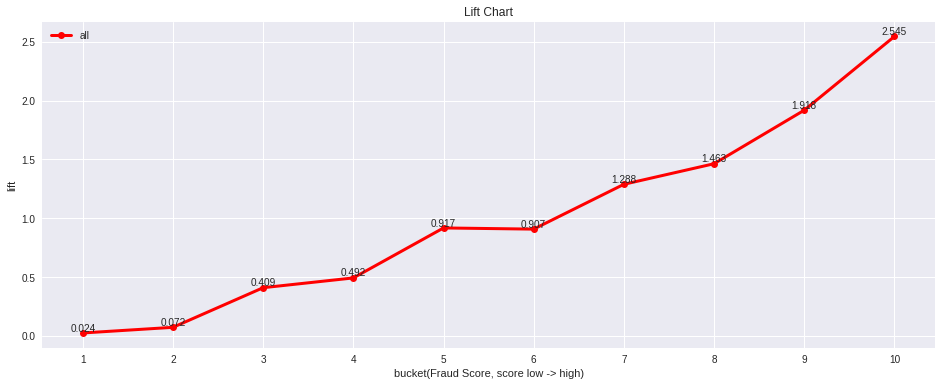

In [12]:
model_ranking_eval(ks_t1, ranking_index='lift', show_data=1)

In [80]:
model_ranking_eval?

In [13]:
ks_table(input_df=df[df['group'] == 'seg1'], score_var='score', target_var='Survived', 
         loan_var=None, eff_var=None, 
         bins=10, bin_mode=3,
         score_bmk_list=df[df['group'] == 'seg1']['score'], bin_break_list=None, ascending=0)

,bucket,min_score,max_score,delta_score,total,total_rate,rejects,reject_rate,loans,loan_rate,...,bads,bad_rate,cum_bad_rate,cum_good_rate,odds,lift,cum_lift,ks_sign,ks,max_ks
0,1,0.835127,0.968446,0.133319,55,10.00%,0,0.00%,55,100.00%,...,53,96.36%,23.14%,0.62%,26.5000,2.3144,2.3144,+,22.52,
1,2,0.685439,0.833946,0.148506,55,10.00%,0,0.00%,55,100.00%,...,46,83.64%,43.23%,3.42%,5.1111,2.0087,2.1616,+,39.82,
2,3,0.553896,0.678866,0.124969,55,10.00%,0,0.00%,55,100.00%,...,37,67.27%,59.39%,9.01%,2.0556,1.6157,1.9796,+,50.38,
3,4,0.451904,0.552215,0.100311,55,10.00%,0,0.00%,55,100.00%,...,29,52.73%,72.05%,17.08%,1.1154,1.2664,1.8013,+,54.97,<<<<<<
4,5,0.353568,0.449175,0.095607,55,10.00%,0,0.00%,55,100.00%,...,17,30.91%,79.48%,28.88%,0.4474,0.7424,1.5895,+,50.59,
5,6,0.300845,0.352368,0.051524,55,10.00%,0,0.00%,55,100.00%,...,19,34.55%,87.77%,40.06%,0.5278,0.8297,1.4629,+,47.71,
6,7,0.258494,0.299822,0.041328,54,9.82%,0,0.00%,54,100.00%,...,12,22.22%,93.01%,53.11%,0.2857,0.5337,1.3322,+,39.91,
7,8,0.163905,0.257758,0.093853,55,10.00%,0,0.00%,55,100.00%,...,12,21.82%,98.25%,66.46%,0.2791,0.5240,1.2310,+,31.79,
8,9,0.103033,0.160611,0.057578,56,10.18%,0,0.00%,56,100.00%,...,3,5.36%,99.56%,82.92%,0.0566,0.1287,1.1063,+,16.64,
9,10,0.034719,0.099007,0.064288,55,10.00%,0,0.00%,55,100.00%,...,1,1.82%,100.00%,99.69%,0.0185,0.0437,1.0000,+,0.31,


In [85]:
ks_table(input_df=df, score_var='score', target_var='Survived', 
         loan_var=None, eff_var=None, 
         bins=10, bin_mode=3,
         score_bmk_list=df[df['group'] == 'seg1']['score'], bin_break_list=None, ascending=0)

,bucket,min_score,max_score,delta_score,total,total_rate,rejects,reject_rate,loans,loan_rate,...,bads,bad_rate,cum_bad_rate,cum_good_rate,odds,lift,cum_lift,ks_sign,ks,max_ks
0,1,0.835127,0.968446,0.133319,59,6.64%,0,0.00%,59,100.00%,...,57,96.61%,16.67%,0.36%,28.5000,2.5113,2.5113,+,16.30,
1,2,0.679732,0.833946,0.154214,77,8.66%,0,0.00%,77,100.00%,...,68,88.31%,36.55%,2.00%,7.5556,2.2956,2.3892,+,34.55,
2,3,0.553896,0.678866,0.124969,75,8.44%,0,0.00%,75,100.00%,...,45,60.00%,49.71%,7.47%,1.5000,1.5596,2.0943,+,42.24,
3,4,0.451904,0.552215,0.100311,96,10.80%,0,0.00%,96,100.00%,...,54,56.25%,65.50%,15.12%,1.2857,1.4622,1.8966,+,50.38,
4,5,0.353568,0.449175,0.095607,139,15.64%,0,0.00%,139,100.00%,...,54,38.85%,81.29%,30.60%,0.6353,1.0098,1.6203,+,50.69,<<<<<<
5,6,0.300845,0.352368,0.051524,78,8.77%,0,0.00%,78,100.00%,...,28,35.90%,89.47%,39.71%,0.5600,0.9331,1.5180,+,49.77,
6,7,0.258494,0.299822,0.041328,63,7.09%,0,0.00%,63,100.00%,...,13,20.63%,93.27%,48.82%,0.2600,0.5364,1.4126,+,44.46,
7,8,0.163905,0.257758,0.093853,88,9.90%,0,0.00%,88,100.00%,...,16,18.18%,97.95%,61.93%,0.2222,0.4726,1.2901,+,36.02,
8,9,0.099358,0.160611,0.061253,109,12.26%,0,0.00%,109,100.00%,...,6,5.50%,99.71%,80.69%,0.0583,0.1431,1.1306,+,19.02,
9,10,0.028756,0.099007,0.070251,105,11.81%,0,0.00%,105,100.00%,...,1,0.95%,100.00%,99.64%,0.0096,0.0248,1.0000,+,0.36,


In [86]:
ks_table(input_df=df, score_var='score', target_var='Survived', 
         loan_var=None, eff_var=None, 
         bins=10, bin_mode=4,
         score_bmk_list=None, bin_break_list=[0, 0.2, 0.6, 0.7, 0.8, 1], ascending=0)

,bucket,min_score,max_score,delta_score,total,total_rate,rejects,reject_rate,loans,loan_rate,...,bads,bad_rate,cum_bad_rate,cum_good_rate,odds,lift,cum_lift,ks_sign,ks,max_ks
0,1,0.800035,0.968446,0.168410,77,8.64%,0,0.00%,77,100.00%,...,75,97.40%,21.93%,0.36%,37.5000,2.5376,2.5376,+,21.57,
1,2,0.710238,0.794839,0.084601,46,5.16%,0,0.00%,46,100.00%,...,39,84.78%,33.33%,1.64%,5.5714,2.2088,2.4146,+,31.69,
2,3,0.601145,0.699099,0.097954,60,6.73%,0,0.00%,60,100.00%,...,40,66.67%,45.03%,5.28%,2.0000,1.7368,2.1924,+,39.75,
3,4,0.201230,0.598180,0.396950,452,50.73%,0,0.00%,452,100.00%,...,175,38.72%,96.20%,55.74%,0.6318,1.0087,1.3498,+,40.46,<<<<<<
4,5,0.024742,0.198938,0.174196,256,28.73%,0,0.00%,256,100.00%,...,13,5.08%,100.00%,100.00%,0.0535,0.1323,1.0000,+,0.00,


In [219]:
ks_g = ks_grouply_table(input_df=df, score_var='score', target_var='Survived', 
                 loan_var=None, eff_var=None, 
                 bins=10, bin_mode=2, group_var='group', group_list=None,
                 score_bmk_list=df[df['group'] == 'seg1']['score'], bin_break_list=None, ascending=False,
                 save_file_path=None)
ks_g

,bucket,min_score,max_score,delta_score,total,total_rate,rejects,reject_rate,loans,loan_rate,...,cum_bad_rate,cum_good_rate,odds,lift,cum_lift,ks_sign,ks,max_ks,group,bin_mode
0,1,0.875561,0.968446,0.092885,37,6.72%,0,0.00%,37,100.00%,...,16.16%,0.00%,inf,2.4061,2.4061,+,16.16,,seg1,equal_dist
1,2,0.787754,0.872664,0.084910,38,6.90%,0,0.00%,38,100.00%,...,31.88%,0.62%,18.0000,2.2795,2.3420,+,31.26,,seg1,equal_dist
2,3,0.689732,0.775447,0.085715,34,6.17%,0,0.00%,34,100.00%,...,43.23%,3.11%,3.2500,1.8400,2.1854,+,40.13,,seg1,equal_dist
3,4,0.592779,0.685439,0.092661,32,5.81%,0,0.00%,32,100.00%,...,52.84%,6.21%,2.2000,1.6542,2.0648,+,46.63,,seg1,equal_dist
4,5,0.498497,0.591121,0.092624,53,9.62%,0,0.00%,53,100.00%,...,65.50%,13.66%,1.2083,1.3166,1.8604,+,51.84,,seg1,equal_dist
5,6,0.406508,0.496916,0.090408,38,6.90%,0,0.00%,38,100.00%,...,74.24%,19.25%,1.1111,1.2664,1.7631,+,54.98,<<<<<<,seg1,equal_dist
6,7,0.311013,0.403556,0.092543,80,14.52%,0,0.00%,80,100.00%,...,84.72%,36.65%,0.4286,0.7218,1.4961,+,48.07,,seg1,equal_dist
7,8,0.222575,0.306412,0.083837,97,17.60%,0,0.00%,97,100.00%,...,95.20%,59.32%,0.3288,0.5953,1.2825,+,35.88,,seg1,equal_dist
8,9,0.122524,0.213832,0.091308,69,12.52%,0,0.00%,69,100.00%,...,99.56%,77.64%,0.1695,0.3487,1.1477,+,21.92,,seg1,equal_dist
9,10,0.027673,0.121406,0.093733,73,13.25%,0,0.00%,73,100.00%,...,100.00%,100.00%,0.0139,0.0330,1.0000,+,0.00,,seg1,equal_dist


> score类似<欺诈分>, 取值越大，P(bad)越大.


<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.6/site-packages/matplotlib/pyplot.py'>

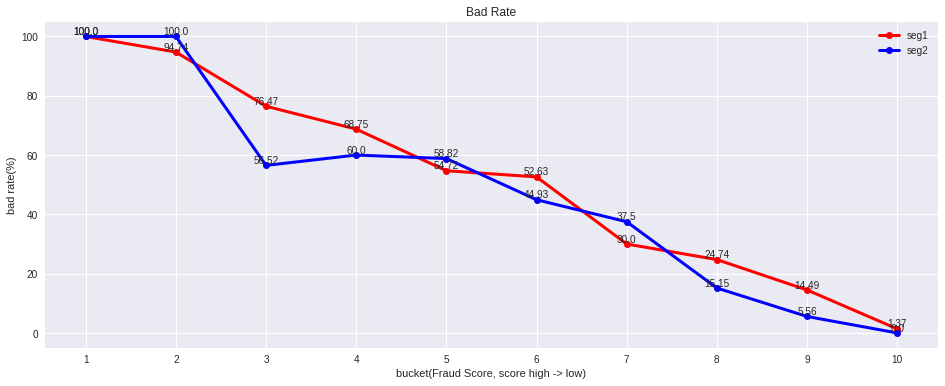

In [225]:
model_ranking_eval(ks_g, ranking_index='bad_rate', group_var='group', show_data=1)

In [60]:
cols = df.columns
cols_type_dict = dict(df.dtypes)
d_cols = [x for x in cols if cols_type_dict[x] == object]
d_cols

['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked', 'group']

In [72]:
var_cluster(input_df=df, n_clusters=3)

NameError: name 'var_cluster' is not defined

In [176]:
SparkSession?

In [167]:
values = [("a", 23), ("b", 45), ("c", 10), ("d", 60), ("e", 56), ("f", 2), ("g", 25), ("h", 40), ("j", 33)]

df = spark.createDataFrame(values, ["name", "ages"])
df

DataFrame[name: string, ages: bigint]

In [175]:
df.select("name").show()

Py4JJavaError: An error occurred while calling o246.showString.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 4.0 failed 1 times, most recent failure: Lost task 0.0 in stage 4.0 (TID 4, localhost, executor driver): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/opt/spark/python/lib/pyspark.zip/pyspark/worker.py", line 125, in main
    ("%d.%d" % sys.version_info[:2], version))
Exception: Python in worker has different version 2.7 than that in driver 3.6, PySpark cannot run with different minor versions.Please check environment variables PYSPARK_PYTHON and PYSPARK_DRIVER_PYTHON are correctly set.

	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRDD.scala:193)
	at org.apache.spark.api.python.PythonRunner$$anon$1.<init>(PythonRDD.scala:234)
	at org.apache.spark.api.python.PythonRunner.compute(PythonRDD.scala:152)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:63)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:87)
	at org.apache.spark.scheduler.Task.run(Task.scala:99)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:322)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1142)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:617)
	at java.lang.Thread.run(Thread.java:745)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1435)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1423)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1422)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1422)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:802)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:802)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:802)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1650)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1605)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1594)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:628)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1956)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1969)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1982)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:333)
	at org.apache.spark.sql.execution.CollectLimitExec.executeCollect(limit.scala:38)
	at org.apache.spark.sql.Dataset$$anonfun$org$apache$spark$sql$Dataset$$execute$1$1.apply(Dataset.scala:2386)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:57)
	at org.apache.spark.sql.Dataset.withNewExecutionId(Dataset.scala:2788)
	at org.apache.spark.sql.Dataset.org$apache$spark$sql$Dataset$$execute$1(Dataset.scala:2385)
	at org.apache.spark.sql.Dataset.org$apache$spark$sql$Dataset$$collect(Dataset.scala:2392)
	at org.apache.spark.sql.Dataset$$anonfun$head$1.apply(Dataset.scala:2128)
	at org.apache.spark.sql.Dataset$$anonfun$head$1.apply(Dataset.scala:2127)
	at org.apache.spark.sql.Dataset.withTypedCallback(Dataset.scala:2818)
	at org.apache.spark.sql.Dataset.head(Dataset.scala:2127)
	at org.apache.spark.sql.Dataset.take(Dataset.scala:2342)
	at org.apache.spark.sql.Dataset.showString(Dataset.scala:248)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:280)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:214)
	at java.lang.Thread.run(Thread.java:745)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/opt/spark/python/lib/pyspark.zip/pyspark/worker.py", line 125, in main
    ("%d.%d" % sys.version_info[:2], version))
Exception: Python in worker has different version 2.7 than that in driver 3.6, PySpark cannot run with different minor versions.Please check environment variables PYSPARK_PYTHON and PYSPARK_DRIVER_PYTHON are correctly set.

	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRDD.scala:193)
	at org.apache.spark.api.python.PythonRunner$$anon$1.<init>(PythonRDD.scala:234)
	at org.apache.spark.api.python.PythonRunner.compute(PythonRDD.scala:152)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:63)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:87)
	at org.apache.spark.scheduler.Task.run(Task.scala:99)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:322)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1142)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:617)
	... 1 more


In [177]:
# from pyspark.ml.feature import Bucketizer
# bucketizer = Bucketizer(splits=[ 0, 6, 18, 60, float('Inf') ], inputCol="ages", outputCol="buckets")
# df_buck = bucketizer.setHandleInvalid("keep").transform(df)

# df_buck.show()

IllegalArgumentException: 'requirement failed: Column ages must be of type DoubleType but was actually LongType.'

In [48]:
ks_compute(proba_arr=df['score'], target_arr=df[target])

0.5262199213881699

> score类似<欺诈分>, 取值越大，P(bad)越大.
> 升序模式, cum_bad_rate在cum_good_rate下方.


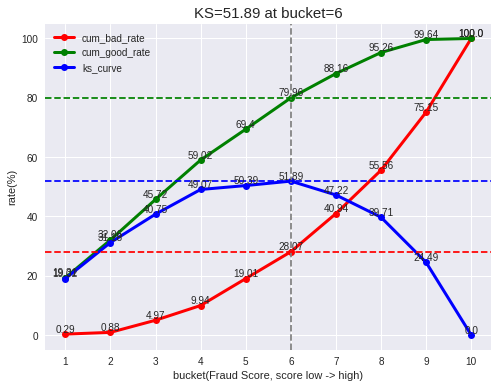

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.6/site-packages/matplotlib/pyplot.py'>

In [227]:
ks_table_plot(input_df=ks_t1)

In [98]:
lr = py_lr.Logistic(X=df[c_cols], y=df[target])

In [7]:
woe = WoE(qnt_num=5, min_block_size=2, spec_values=None, v_type='c', bins=None, t_type='b')
woe1 = woe.fit(df['Age'], df[target])
age_bin_df = woe1.bins.copy()
age_bin_df

,feature,labels,bins,min_score,max_score,obs,bad,good,bad_rate,good_rate,odds_good,woe,bin_iv,iv
0,Age,0,-inf,-inf,18.000000,139,70,69,0.503597,0.496403,0.985714,-0.487676,0.038524,0.087583
1,Age,1,18.000000,18.000000,23.000000,107,33,74,0.308411,0.691589,2.242424,0.334270,0.012802,0.087583
2,Age,2,23.000000,23.000000,28.000000,116,45,71,0.387931,0.612069,1.577778,-0.017270,0.000039,0.087583
3,Age,3,28.000000,28.000000,34.000000,116,48,68,0.413793,0.586207,1.416667,-0.124981,0.002061,0.087583
4,Age,4,34.000000,34.000000,44.000000,121,51,70,0.421488,0.578512,1.372549,-0.156618,0.003386,0.087583
5,Age,5,44.000000,44.000000,inf,115,43,72,0.373913,0.626087,1.674419,0.042178,0.000228,0.087583
6,Age,d_nan,NaN,NaN,NaN,177,52,125,0.293785,0.706215,2.403846,0.403782,0.030542,0.087583


In [38]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'group', 'score'],
      dtype='object')

In [40]:
woe = WoE(qnt_num=5, min_block_size=2, spec_values=None, v_type='d', bins=None, t_type='b')
woe1 = woe.fit(df['Embarked'], df[target])
emb_bin_df = woe1.bins.copy()
emb_bin_df

,feature,labels,bins,min_score,max_score,obs,bad,good,bad_rate,good_rate,odds_good,woe,bin_iv,iv
0,Embarked,d_C,C,C,C,168,93,75,0.553571,0.446429,0.806452,-0.688399,0.093153,0.133249
1,Embarked,d_Q,Q,Q,Q,77,30,47,0.389610,0.610390,1.566667,-0.024337,0.000051,0.133249
2,Embarked,d_S,S,S,S,644,217,427,0.336957,0.663043,1.967742,0.203599,0.029171,0.133249
3,Embarked,d_nan,NaN,NaN,NaN,2,2,0,1.000000,0.000000,0.000000,-1.859582,0.010875,0.133249


In [41]:
emb_bin_df['weight'] = -0.3
emb_bin_df['score']  = round(emb_bin_df['weight'] * beta * emb_bin_df['woe'])
emb_bin_df

,feature,labels,bins,min_score,max_score,obs,bad,good,bad_rate,good_rate,odds_good,woe,bin_iv,iv,weight,score
0,Embarked,d_C,C,C,C,168,93,75,0.553571,0.446429,0.806452,-0.688399,0.093153,0.133249,-0.3,-7.0
1,Embarked,d_Q,Q,Q,Q,77,30,47,0.389610,0.610390,1.566667,-0.024337,0.000051,0.133249,-0.3,-0.0
2,Embarked,d_S,S,S,S,644,217,427,0.336957,0.663043,1.967742,0.203599,0.029171,0.133249,-0.3,2.0
3,Embarked,d_nan,NaN,NaN,NaN,2,2,0,1.000000,0.000000,0.000000,-1.859582,0.010875,0.133249,-0.3,-20.0


In [23]:
from model_scaling import *

In [25]:
scorecard_scaling?

In [24]:
alpha, beta = scorecard_scaling()

评分卡类型为信用评分卡, 分数转换公式为：score = 697.672264890213 + -36.06737602222409 * ln(odds)


In [27]:
age_bin_df['weight'] = -0.2
age_bin_df['score']  = round(age_bin_df['weight'] * beta * age_bin_df['woe'])
age_bin_df

,feature,labels,bins,min_score,max_score,obs,bad,good,bad_rate,good_rate,odds_good,woe,bin_iv,iv,weight,score
0,Age,0,-inf,-inf,18.000000,139,70,69,0.503597,0.496403,0.985714,-0.487676,0.038524,0.087583,-0.2,-4.0
1,Age,1,18.000000,18.000000,23.000000,107,33,74,0.308411,0.691589,2.242424,0.334270,0.012802,0.087583,-0.2,2.0
2,Age,2,23.000000,23.000000,28.000000,116,45,71,0.387931,0.612069,1.577778,-0.017270,0.000039,0.087583,-0.2,-0.0
3,Age,3,28.000000,28.000000,34.000000,116,48,68,0.413793,0.586207,1.416667,-0.124981,0.002061,0.087583,-0.2,-1.0
4,Age,4,34.000000,34.000000,44.000000,121,51,70,0.421488,0.578512,1.372549,-0.156618,0.003386,0.087583,-0.2,-1.0
5,Age,5,44.000000,44.000000,inf,115,43,72,0.373913,0.626087,1.674419,0.042178,0.000228,0.087583,-0.2,0.0
6,Age,d_nan,NaN,NaN,NaN,177,52,125,0.293785,0.706215,2.403846,0.403782,0.030542,0.087583,-0.2,3.0


In [42]:
final_woe_df = pd.concat([age_bin_df, emb_bin_df])
final_woe_df

,feature,labels,bins,min_score,max_score,obs,bad,good,bad_rate,good_rate,odds_good,woe,bin_iv,iv,weight,score
0,Age,0,-inf,-inf,18,139,70,69,0.503597,0.496403,0.985714,-0.487676,0.038524,0.087583,-0.2,-4.0
1,Age,1,18,18,23,107,33,74,0.308411,0.691589,2.242424,0.334270,0.012802,0.087583,-0.2,2.0
2,Age,2,23,23,28,116,45,71,0.387931,0.612069,1.577778,-0.017270,0.000039,0.087583,-0.2,-0.0
3,Age,3,28,28,34,116,48,68,0.413793,0.586207,1.416667,-0.124981,0.002061,0.087583,-0.2,-1.0
4,Age,4,34,34,44,121,51,70,0.421488,0.578512,1.372549,-0.156618,0.003386,0.087583,-0.2,-1.0
5,Age,5,44,44,inf,115,43,72,0.373913,0.626087,1.674419,0.042178,0.000228,0.087583,-0.2,0.0
6,Age,d_nan,NaN,NaN,NaN,177,52,125,0.293785,0.706215,2.403846,0.403782,0.030542,0.087583,-0.2,3.0
0,Embarked,d_C,C,C,C,168,93,75,0.553571,0.446429,0.806452,-0.688399,0.093153,0.133249,-0.3,-7.0
1,Embarked,d_Q,Q,Q,Q,77,30,47,0.389610,0.610390,1.566667,-0.024337,0.000051,0.133249,-0.3,-0.0
2,Embarked,d_S,S,S,S,644,217,427,0.336957,0.663043,1.967742,0.203599,0.029171,0.133249,-0.3,2.0


In [103]:
def bimap_to_sql(input_df, source_table='dm_ds_fraud.fhj_source_table'):
    """
    ----------------------------------------------------------------------
    功能：根据binmap文件生成SQL语句，用于评分卡SQL部署
    ----------------------------------------------------------------------
    :param input_df: pd.DataFrame, 由评分卡脚本生成
    :param source_table: str, 数据源表
    ----------------------------------------------------------------------
    :return sql: str, sql语句
    ----------------------------------------------------------------------
    示例：
    >>> alpha, beta = scorecard_scaling()
    >>> 评分卡类型为信用评分卡, 分数转换公式为：score = 697.672264890213 + -36.06737602222409 * ln(odds)
    
    >>> binmap_df['weight'] = -0.2
    >>> binmap_df['score']  = round(binmap_df['weight'] * beta * binmap_df['woe'])
    >>> binmap_df.head()
    >>>
    	feature	labels	bins	min_score	max_score	obs	bad	good	bad_rate	good_rate	odds_good	woe	bin_iv	iv	weight	score
    0	Age	0	-inf	-inf	18.000000	139	70	69	0.503597	0.496403	0.985714	-0.487676	0.038524	0.087583	-0.2	-4.0
    1	Age	1	18.000000	18.000000	23.000000	107	33	74	0.308411	0.691589	2.242424	0.334270	0.012802	0.087583	-0.2	2.0
    
    >>>
    ----------------------------------------------------------------------
    """
    if 'basescore' in set(input_df.columns):
        base_score = list(input_df['basescore'])[0]
    else:
        base_score = 600
    
    def var_sql(input_df, var):

        bin_label_list = list(input_df['labels'])
        min_score_list = list(input_df['min_score'])
        max_score_list = list(input_df['max_score'])
        score_list = list(input_df['score'])
        bucket_num = len(min_score_list)

        def c_var_sql(var, min_score, max_score, bin_score):
            """
            ----------------------------------------------------------------------
            功能：连续变量生成SQL语句
            ----------------------------------------------------------------------
            :param var: str, 变量名
            :param min_score: float, 分箱下界
            :param max_score: float, 分箱上界
            :param bin_score: int, 分箱得分
            ----------------------------------------------------------------------
            :return sql: str, sql语句
            ----------------------------------------------------------------------
            """
            if math.isinf(min_score):
                sql = "           when {} <= {} then {} \n".format(var, max_score, bin_score)
            elif math.isinf(max_score):
                sql = "           when {} >  {} then {} \n".format(var, min_score, bin_score)
            elif not (math.isnan(min_score) or math.isnan(max_score)):
                sql = "           when {} >  {} and {} <= {} then {} \n".format(var, min_score, var, max_score, bin_score)
            else:
                sql = "           else {} \n       end as {}_score, \n".format(bin_score, var)

            return sql

        def d_var_sql(var, min_score, max_score, bin_score):
            """
            ----------------------------------------------------------------------
            功能：离散变量生成SQL语句
            ----------------------------------------------------------------------
            :param var: str, 变量名
            :param min_score: str, 分箱下界
            :param max_score: str, 分箱上界
            :param bin_score: int, 分箱得分
            ----------------------------------------------------------------------
            :return sql: str, sql语句
            ----------------------------------------------------------------------
            """
            if type(min_score) == str:
                sql = "           when {} in ('{}') then {} \n".format(var, min_score, bin_score)
            else:
                sql = "           else {} \n       end as {}_score, \n".format(bin_score, var)

            return sql

        var_sql = "       case \n"
        for idx in range(bucket_num):
            min_score = min_score_list[idx]
            max_score = max_score_list[idx]
            bin_score = score_list[idx]
            if str(bin_label_list[0]).startswith('d_'):
                sql = d_var_sql(var, min_score, max_score, bin_score)
            else:
                sql = c_var_sql(var, min_score, max_score, bin_score)
            var_sql += sql

        return var_sql 
    
    output_sql =  "select order_id, \n"
    output_sql += "       {} as basescore, \n".format(base_score)
    var_list = sorted(list(set(input_df['feature'])))
    for var in var_list:
        var_input_df = input_df[input_df['feature'] == var]
        output_sql += var_sql(var_input_df, var)
    output_sql += "from {}".format(source_table)
    
    return output_sql

In [104]:
sq = bimap_to_sql(input_df=age_bin_df)
print(sq)

select order_id, 
       600 as basescore, 
       case 
           when Age <= 18.0 then -4.0 
           when Age >  18.0 and Age <= 23.0 then 2.0 
           when Age >  23.0 and Age <= 28.0 then -0.0 
           when Age >  28.0 and Age <= 34.0 then -1.0 
           when Age >  34.0 and Age <= 44.0 then -1.0 
           when Age >  44.0 then 0.0 
           else 3.0 
       end as Age_score, 
from dm_ds_fraud.fhj_source_table


In [105]:
sq = bimap_to_sql(input_df=final_woe_df)
print(sq)

select order_id, 
       600 as basescore, 
       case 
           when Age <= 18.0 then -4.0 
           when Age >  18.0 and Age <= 23.0 then 2.0 
           when Age >  23.0 and Age <= 28.0 then -0.0 
           when Age >  28.0 and Age <= 34.0 then -1.0 
           when Age >  34.0 and Age <= 44.0 then -1.0 
           when Age >  44.0 then 0.0 
           else 3.0 
       end as Age_score, 
       case 
           when Embarked in ('C') then -7.0 
           when Embarked in ('Q') then -0.0 
           when Embarked in ('S') then 2.0 
           else -20.0 
       end as Embarked_score, 
from dm_ds_fraud.fhj_source_table


In [21]:
import seaborn as sns

def var_batch_woe_binning(input_df, target_var, c_var_list, d_var_list, qnt_num=5, file_path='/home/jovyan/01 风控建模标准化/test'):
    
    binmap = pd.DataFrame()
          
    d_woe = py_woe.WoE(qnt_num=qnt_num, min_block_size=2, spec_values=None, v_type='d', bins=None, t_type='b')
    for var in d_var_list:
        woe1 = d_woe.fit(df[var], df[target_var])
        binmap = pd.concat([binmap, woe1.bins])
        woe_fig = woe1.plot()
        woe_fig.savefig(file_path + '/{}_woe.jpg'.format(var))
        
    c_woe = py_woe.WoE(qnt_num=qnt_num, min_block_size=2, spec_values=None, v_type='c', bins=None, t_type='b')
    for var in c_var_list:
        plt.figure(figsize=(6.0, 4.0))
        dis_fig = sns.distplot(input_df[var].dropna())
        plt.savefig(file_path + '/{}_dis.jpg'.format(var))
        
        woe1 = c_woe.fit(input_df[var], input_df[target_var])
        binmap = pd.concat([binmap, woe1.bins])
        woe_fig = woe1.plot()
        woe_fig.savefig(file_path + '/{}_woe.jpg'.format(var))
        
    return binmap


In [25]:
len(set(df['Cabin']))

148

In [67]:
d_woe = WoE(qnt_num=2, min_block_size=3, spec_values=None, v_type='d', bins=None, t_type='b')
woe1 = d_woe.fit(df['Cabin'], df[target], max_buckets=200)
woe1.bins

,feature,labels,bins,min_score,max_score,obs,bad,good,bad_rate,good_rate,odds_good,woe,bin_iv,iv
0,Cabin,d_A10,A10,A10,A10,1,0,1,0.000000,1.000000,inf,0.219859,0.000400,0.675575
1,Cabin,d_A14,A14,A14,A14,1,0,1,0.000000,1.000000,inf,0.219859,0.000400,0.675575
2,Cabin,d_A16,A16,A16,A16,1,1,0,1.000000,0.000000,0.000000,-1.166435,0.003411,0.675575
3,Cabin,d_A19,A19,A19,A19,1,0,1,0.000000,1.000000,inf,0.219859,0.000400,0.675575
4,Cabin,d_A20,A20,A20,A20,1,1,0,1.000000,0.000000,0.000000,-1.166435,0.003411,0.675575
5,Cabin,d_A23,A23,A23,A23,1,1,0,1.000000,0.000000,0.000000,-1.166435,0.003411,0.675575
6,Cabin,d_A24,A24,A24,A24,1,0,1,0.000000,1.000000,inf,0.219859,0.000400,0.675575
7,Cabin,d_A26,A26,A26,A26,1,1,0,1.000000,0.000000,0.000000,-1.166435,0.003411,0.675575
8,Cabin,d_A31,A31,A31,A31,1,1,0,1.000000,0.000000,0.000000,-1.166435,0.003411,0.675575
9,Cabin,d_A32,A32,A32,A32,1,0,1,0.000000,1.000000,inf,0.219859,0.000400,0.675575


/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


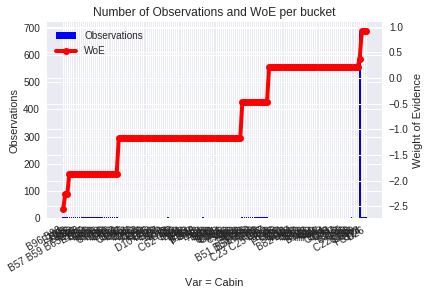

In [70]:
a = woe1.plot()

In [73]:
var_bin_map = d_woe.disc_merge()
df['binned_carbin'] = df['Cabin'].apply(lambda x: var_bin_map[x])

In [76]:
var_bin_map

{nan: 'd_1',
 'C22 C26': 'd_1',
 'C23 C25 C27': 'd_1',
 'G6': 'd_1',
 'D': 'd_0',
 'F2': 'd_0',
 'E101': 'd_0',
 'F33': 'd_0',
 'B96 B98': 'd_0',
 'A10': 'd_2',
 'A14': 'd_2',
 'A16': 'd_2',
 'A19': 'd_2',
 'A20': 'd_2',
 'A23': 'd_2',
 'A24': 'd_2',
 'A26': 'd_2',
 'A31': 'd_2',
 'A32': 'd_2',
 'A34': 'd_2',
 'A36': 'd_2',
 'A5': 'd_2',
 'A6': 'd_2',
 'A7': 'd_2',
 'B101': 'd_2',
 'B102': 'd_2',
 'B18': 'd_2',
 'B19': 'd_2',
 'B20': 'd_2',
 'B22': 'd_2',
 'B28': 'd_2',
 'B3': 'd_2',
 'B30': 'd_2',
 'B35': 'd_2',
 'B37': 'd_2',
 'B38': 'd_2',
 'B39': 'd_2',
 'B4': 'd_2',
 'B41': 'd_2',
 'B42': 'd_2',
 'B49': 'd_2',
 'B5': 'd_2',
 'B50': 'd_2',
 'B51 B53 B55': 'd_2',
 'B57 B59 B63 B66': 'd_2',
 'B58 B60': 'd_2',
 'B69': 'd_2',
 'B71': 'd_2',
 'B73': 'd_2',
 'B77': 'd_2',
 'B78': 'd_2',
 'B79': 'd_2',
 'B80': 'd_2',
 'B82 B84': 'd_2',
 'B86': 'd_2',
 'B94': 'd_2',
 'C101': 'd_2',
 'C103': 'd_2',
 'C104': 'd_2',
 'C106': 'd_2',
 'C110': 'd_2',
 'C111': 'd_2',
 'C118': 'd_2',
 'C123': 'd_2

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


,feature,labels,bins,min_score,max_score,obs,bad,good,bad_rate,good_rate,odds_good,woe,bin_iv,iv
0,binned_carbin,d_d_0,d_0,d_0,d_0,16,14,2,0.875000,0.125000,0.142857,-2.419198,0.090218,0.45397
1,binned_carbin,d_d_1,d_1,d_1,d_1,698,211,487,0.302292,0.697708,2.308057,0.363118,0.098081,0.45397
2,binned_carbin,d_d_2,d_2,d_2,d_2,177,117,60,0.661017,0.338983,0.512821,-1.141117,0.265670,0.45397


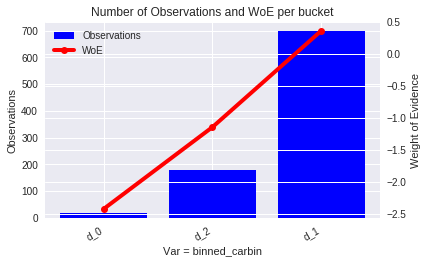

In [75]:
d_woe2 = py_woe.WoE(qnt_num=5, min_block_size=10, spec_values=None, v_type='d', bins=None, t_type='b')
woe2 = d_woe2.fit(df['binned_carbin'], df[target], max_buckets=200)
d = woe2.plot()
woe2.bins

In [46]:
var_bin_map = {}
min_block_size = 2
woe_df1 = woe1.bins[woe1.bins['obs'] < min_block_size]
woe_df2 = woe1.bins[woe1.bins['obs'] >= min_block_size].reset_index(drop=1)
woe_df2 = woe_df2.sort_values(by=['woe'], ascending=0).reset_index(drop=1)
cuts, bins = pd.qcut(woe_df2["woe"], 5, retbins=True, labels=False, duplicates='drop')
woe_df2['new_bin'] = cuts

for idx, var in enumerate(woe_df2['bins']):
    var_bin_map[var] = 'd_{}'.format(cuts[idx])
    
for idx, var in enumerate(woe_df1['bins']):
    var_bin_map[var] = 'd_{}'.format(max(cuts)+1)

In [47]:
var_bin_map

{'C124': 'd_3',
 'F G73': 'd_3',
 'D26': 'd_3',
 nan: 'd_3',
 'C22 C26': 'd_3',
 'G6': 'd_2',
 'E67': 'd_2',
 'E44': 'd_2',
 'C78': 'd_2',
 'C68': 'd_2',
 'C65': 'd_2',
 'C23 C25 C27': 'd_2',
 'C2': 'd_2',
 'C83': 'd_2',
 'B51 B53 B55': 'd_2',
 'C123': 'd_2',
 'B22': 'd_2',
 'B58 B60': 'd_2',
 'F2': 'd_1',
 'D': 'd_1',
 'B49': 'd_0',
 'E24': 'd_0',
 'E25': 'd_0',
 'E33': 'd_0',
 'C125': 'd_0',
 'B35': 'd_0',
 'E8': 'd_0',
 'D36': 'd_0',
 'B28': 'd_0',
 'F4': 'd_0',
 'E121': 'd_0',
 'D33': 'd_0',
 'D35': 'd_0',
 'C126': 'd_0',
 'B5': 'd_0',
 'D20': 'd_0',
 'D17': 'd_0',
 'C93': 'd_0',
 'C92': 'd_0',
 'B20': 'd_0',
 'B57 B59 B63 B66': 'd_0',
 'C52': 'd_0',
 'B77': 'd_0',
 'B18': 'd_0',
 'E101': 'd_0',
 'F33': 'd_0',
 'B96 B98': 'd_0',
 'A10': 'd_4',
 'A14': 'd_4',
 'A16': 'd_4',
 'A19': 'd_4',
 'A20': 'd_4',
 'A23': 'd_4',
 'A24': 'd_4',
 'A26': 'd_4',
 'A31': 'd_4',
 'A32': 'd_4',
 'A34': 'd_4',
 'A36': 'd_4',
 'A5': 'd_4',
 'A6': 'd_4',
 'A7': 'd_4',
 'B101': 'd_4',
 'B102': 'd_4',
 'B

In [41]:
woe_df2

,feature,labels,bins,min_score,max_score,obs,bad,good,bad_rate,good_rate,odds_good,woe,bin_iv,iv,new_bin
13,Cabin,d_C124,C124,C124,C124,2,0,2,0.000000,1.000000,inf,0.913007,0.003326,0.675575,3
41,Cabin,d_F G73,F G73,F G73,F G73,2,0,2,0.000000,1.000000,inf,0.913007,0.003326,0.675575,3
29,Cabin,d_D26,D26,D26,D26,2,0,2,0.000000,1.000000,inf,0.913007,0.003326,0.675575,3
46,Cabin,d_nan,NaN,NaN,NaN,687,206,481,0.299854,0.700146,2.334951,0.374703,0.102594,0.675575,3
17,Cabin,d_C22 C26,C22 C26,C22 C26,C22 C26,3,1,2,0.333333,0.666667,2.000000,0.219859,0.000158,0.675575,3
45,Cabin,d_G6,G6,G6,G6,4,2,2,0.500000,0.500000,1.000000,-0.473288,0.001044,0.675575,2
39,Cabin,d_E67,E67,E67,E67,2,1,1,0.500000,0.500000,1.000000,-0.473288,0.000522,0.675575,2
38,Cabin,d_E44,E44,E44,E44,2,1,1,0.500000,0.500000,1.000000,-0.473288,0.000522,0.675575,2
22,Cabin,d_C78,C78,C78,C78,2,1,1,0.500000,0.500000,1.000000,-0.473288,0.000522,0.675575,2
21,Cabin,d_C68,C68,C68,C68,2,1,1,0.500000,0.500000,1.000000,-0.473288,0.000522,0.675575,2


In [ ]:
def discrete_binning(input_df, target_var, min_block_size=10):
    

In [ ]:
sns.distplot(input_df[var].dropna())

In [ ]:
def batch_dist_plot(input_df, target_var, c_var_list, d_var_list, file_path):
    import seaborn as sns

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/opt/conda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


,feature,labels,bins,min_score,max_score,obs,bad,good,bad_rate,good_rate,odds_good,woe,bin_iv,iv
0,Embarked,d_C,C,C,C,168,93,75,0.553571,0.446429,0.806452,-0.688399,0.093153,0.133249
1,Embarked,d_Q,Q,Q,Q,77,30,47,0.389610,0.610390,1.566667,-0.024337,0.000051,0.133249
2,Embarked,d_S,S,S,S,644,217,427,0.336957,0.663043,1.967742,0.203599,0.029171,0.133249
3,Embarked,d_nan,NaN,NaN,NaN,2,2,0,1.000000,0.000000,0.000000,-1.859582,0.010875,0.133249
0,Parch,d_0,0,0,0,678,233,445,0.343658,0.656342,1.909871,0.173748,0.022462,0.127274
1,Parch,d_1,1,1,1,118,65,53,0.550847,0.449153,0.815385,-0.677383,0.063348,0.127274
2,Parch,d_2,2,2,2,80,40,40,0.500000,0.500000,1.000000,-0.473288,0.020872,0.127274
3,Parch,d_3,3,3,3,5,3,2,0.600000,0.400000,0.666667,-0.878753,0.004507,0.127274
4,Parch,d_4,4,4,4,4,0,4,0.000000,1.000000,inf,1.606154,0.011702,0.127274
5,Parch,d_5,5,5,5,5,1,4,0.200000,0.800000,4.000000,0.913007,0.003983,0.127274


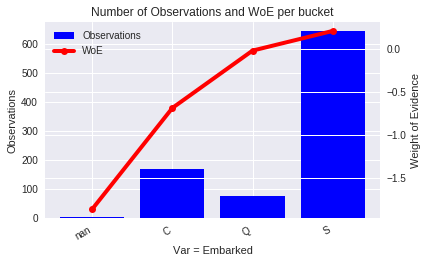

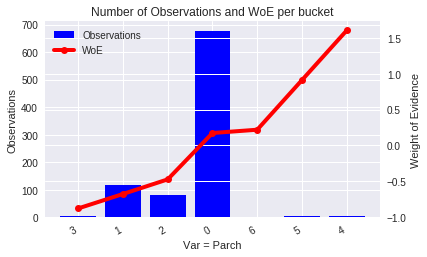

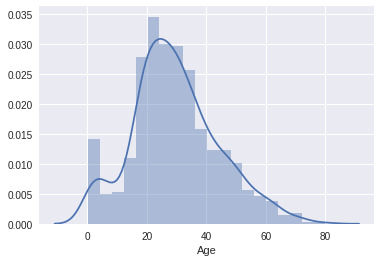

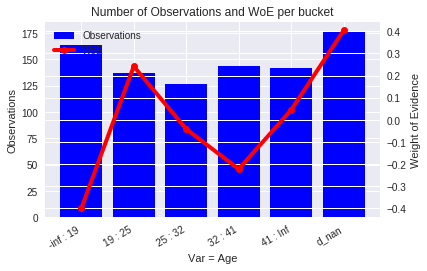

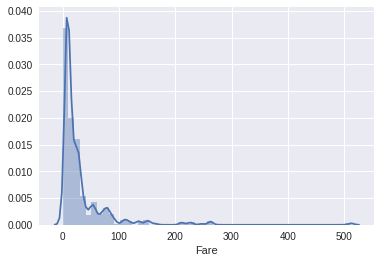

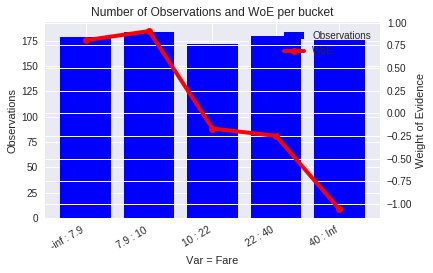

In [22]:
batch_woe(input_df=df, target_var=target, c_var_list=c_cols, d_var_list=[], qnt_num=4)

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


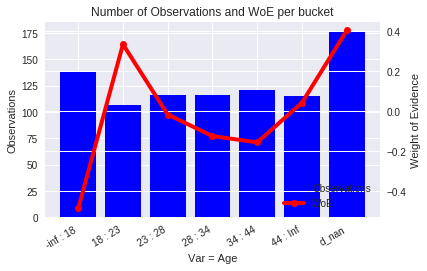

In [177]:
fig = woe1.plot()
plt.show(fig)

In [206]:
#coding: utf-8
import xlsxwriter
workbook = xlsxwriter.Workbook('chart_column.xlsx')
worksheet = workbook.add_worksheet()
bold = workbook.add_format({'bold': 1})
# 这是个数据table的列
headings = ['Number', 'Batch 1', 'Batch 2']
data = [
 [2, 3, 4, 5, 6, 7],
 [10, 40, 50, 20, 10, 50],
 [30, 60, 70, 50, 40, 30],
]
worksheet.write_row('A1', headings, bold)
worksheet.write_column('A2', data[0])
worksheet.write_column('B2', data[1])
worksheet.write_column('C2', data[2])
############################################
#创建一个图表，类型是column
chart1 = workbook.add_chart({'type': 'column'})
# 配置series,这个和前面wordsheet是有关系的。
chart1.add_series({
 'name':  '=Sheet1!$B$1',
 'categories': '=Sheet1!$A$2:$A$7',
 'values':  '=Sheet1!$B$2:$B$7',
})
# Configure a second series. Note use of alternative syntax to define ranges.
chart1.add_series({
 'name':  ['Sheet1', 0, 2],
 'categories': ['Sheet1', 1, 0, 6, 0],
 'values':  ['Sheet1', 1, 2, 6, 2],
})
# Add a chart title and some axis labels.
chart1.set_title ({'name': 'Results of sample analysis'})
chart1.set_x_axis({'name': 'Test number'})
chart1.set_y_axis({'name': 'Sample length (mm)'})
# Set an Excel chart style.
chart1.set_style(11)
# Insert the chart into the worksheet (with an offset).
worksheet.insert_chart('D2', chart1, {'x_offset': 25, 'y_offset': 10})
#######################################################################
#
# Create a stacked chart sub-type.
#
chart2 = workbook.add_chart({'type': 'column', 'subtype': 'stacked'})
# Configure the first series.
chart2.add_series({
 'name':  '=Sheet1!$B$1',
 'categories': '=Sheet1!$A$2:$A$7',
 'values':  '=Sheet1!$B$2:$B$7',
})
# Configure second series.
chart2.add_series({
 'name':  '=Sheet1!$C$1',
 'categories': '=Sheet1!$A$2:$A$7',
 'values':  '=Sheet1!$C$2:$C$7',
})
# Add a chart title and some axis labels.
chart2.set_title ({'name': 'Stacked Chart'})
chart2.set_x_axis({'name': 'Test number'})
chart2.set_y_axis({'name': 'Sample length (mm)'})
# Set an Excel chart style.
chart2.set_style(12)
# Insert the chart into the worksheet (with an offset).
worksheet.insert_chart('D18', chart2, {'x_offset': 25, 'y_offset': 10})
#######################################################################
#
# Create a percentage stacked chart sub-type.
#
chart3 = workbook.add_chart({'type': 'column', 'subtype': 'percent_stacked'})
# Configure the first series.
chart3.add_series({
 'name':  '=Sheet1!$B$1',
 'categories': '=Sheet1!$A$2:$A$7',
 'values':  '=Sheet1!$B$2:$B$7',
})
# Configure second series.
chart3.add_series({
 'name':  '=Sheet1!$C$1',
 'categories': '=Sheet1!$A$2:$A$7',
 'values':  '=Sheet1!$C$2:$C$7',
})
# Add a chart title and some axis labels.
chart3.set_title ({'name': 'Percent Stacked Chart'})
chart3.set_x_axis({'name': 'Test number'})
chart3.set_y_axis({'name': 'Sample length (mm)'})
# Set an Excel chart style.
chart3.set_style(13)
# Insert the chart into the worksheet (with an offset).
worksheet.insert_chart('D34', chart3, {'x_offset': 25, 'y_offset': 10})
workbook.close()


In [210]:
worksheet.insert_image?

In [3]:
range?

In [22]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

data = np.random.randn(1000)
#最基本的频次直方图命令

In [41]:
plt.hist?

In [38]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'group'],
      dtype='object')

In [5]:
df['dummy'] = 1
grouped = df.groupby(['Embarked'])

In [7]:
stat = grouped.count()['dummy']
stat

Embarked
C    168
Q     77
S    644
Name: dummy, dtype: int64

In [8]:
stat.index

Index(['C', 'Q', 'S'], dtype='object', name='Embarked')

In [12]:
list(stat)

[168, 77, 644]

In [15]:
plt.hist?

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


AttributeError: 'NoneType' object has no attribute 'update'

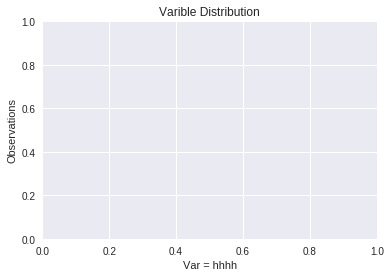

In [18]:
fig = plt.figure()
plt.title('Varible Distribution')
ax = fig.add_subplot(111)
ax.set_xlabel('Var = {}'.format('hhhh'))
ax.set_ylabel('Observations')

df['dummy'] = 1
grouped = df.groupby(['Embarked'])
stat = grouped.count()['dummy']
stat['var'] = stat.index
del df['dummy']

plt.hist(x=stat)
# plt.plot(x, y, label=g, linewidth=3, marker='o', color=color, linestyle=linestyle)
fig.autofmt_xdate()

In [20]:
import os
import xlsxwriter
workbook = xlsxwriter.Workbook('fhj_test.xlsx') # 修改需保存的文件名
worksheet = workbook.add_worksheet()
bold = workbook.add_format({'bold': 1})

# 输入存放图片的文件夹路径
file_path = './test/'

jpg_list = sorted(os.listdir(file_path))
var_list = sorted(list(set([x.split('_')[0] for x in jpg_list])))
pos_list = [x for x in range(2, 200, 8)]

for idx, var in enumerate(var_list):
    pos = pos_list[idx]
    if os.path.exists(file_path + '{}_dis.jpg'.format(var)):
        worksheet.insert_image('B{}'.format(pos), file_path + '{}_dis.jpg'.format(var), {'x_scale': 0.4, 'y_scale': 0.4})
    
    if os.path.exists(file_path + '{}_woe.jpg'.format(var)):
        worksheet.insert_image('F{}'.format(pos), file_path + '{}_woe.jpg'.format(var), {'x_scale': 0.4, 'y_scale': 0.4})
workbook.close()



In [209]:
workbook.add_chart?

In [ ]:
worksheet.

In [185]:
fig.savefig('xxx.jpg')

In [174]:
woe1_op = woe1.optimize()

In [175]:
woe1_op._is_woe_monotonic()

True

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


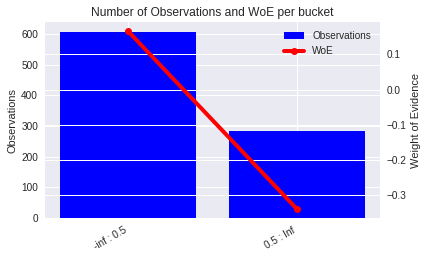

In [176]:
fig = woe1_op2.plot()
plt.show(fig)

In [121]:
woe1._is_woe_monotonic()

False

In [ ]:
woe = WoE(qnt_num=4, min_block_size=2, spec_values=None, v_type='d', bins=None, t_type='b')
woe1 = woe.fit(df['Embarked'], df[target])
woe1.bins

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


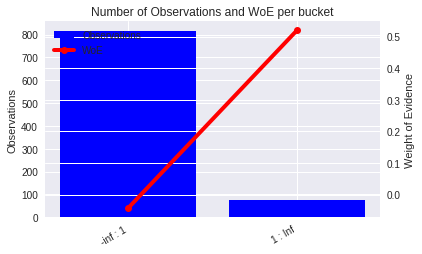

,feature,labels,bins,min_score,max_score,obs,bad,good,bad_rate,good_rate,odds_good,woe,bin_iv,iv
0,SibSp,0,-inf,-inf,-inf,817,322,495,0.394125,0.605875,1.537267,-0.043281,0.001726,0.022463
1,SibSp,1,1.000000,1.000000,1.000000,74,20,54,0.270270,0.729730,2.700000,0.519964,0.020737,0.022463


In [170]:
woe2 = woe1.force_monotonic()
fig2 = woe2.plot()
plt.show(fig2)
woe2.bins

In [171]:
woe2._is_woe_monotonics()

AttributeError: 'WoE' object has no attribute '_is_woe_monotonics'

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


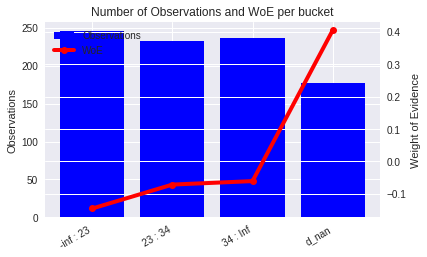

In [39]:
woe3 = woe1.force_monotonic()
fig3 = woe3.plot()
plt.show(fig3)

In [41]:
woe_df = woe2.bins
woe_df 

,feature,labels,bins,min_score,max_score,obs,bad,good,bad_rate,good_rate,odds_good,woe
0,X,0,-inf,-inf,20.125000,179,82,97,0.458101,0.541899,1.182927,-0.305296
1,X,1,20.125000,20.125000,38.000000,358,142,216,0.396648,0.603352,1.521127,-0.053836
2,X,2,38.000000,38.000000,inf,177,66,111,0.372881,0.627119,1.681818,0.046588
3,X,d_nan,NaN,NaN,NaN,177,52,125,0.293785,0.706215,2.403846,0.403782


In [3]:
from model_scaling import *

In [5]:
alpha, beta = scorecard_scaling()

评分卡类型为信用评分卡, 分数转换公式为：score = 697.672264890213 + -36.06737602222409 * ln(odds)


In [ ]:
woe_df['score'] = woe_df['odds_goods']

In [43]:
import numpy
data = numpy.random.random(100)
bins = numpy.linspace(0, 1, 10)
digitized = numpy.digitize(data, bins)
bin_means = [data[digitized == i].mean() for i in range(1, len(bins))]

In [41]:
def binning_cate(df,col_list,target):
    """
    df:数据集
    col_list:变量list集合
    target:目标变量的字段名
    
    return: 
    bin_df :list形式，里面存储每个变量的分箱结果
    iv_value:list形式，里面存储每个变量的IV值
    """
    total = df[target].count()
    bad = df[target].sum()
    good = total-bad
    all_odds = good*1.0/bad
    bin_df =[]
    iv_value=[]
    for col in col_list:
        d1 = df.groupby([col],as_index=True)
        d2 = pd.DataFrame()
        d2['min_bin'] = d1[col].min()
        d2['max_bin'] = d1[col].max()
        d2['total'] = d1[target].count()
        d2['totalrate'] = d2['total']/total
        d2['bad'] = d1[target].sum()
        d2['badrate'] = d2['bad']/d2['total']
        d2['good'] = d2['total'] - d2['bad']
        d2['goodrate'] = d2['good']/d2['total']
        d2['badattr'] = d2['bad']/bad
        d2['goodattr'] = (d2['total']-d2['bad'])/good
        d2['odds'] = d2['good']/d2['bad']
        GB_list=[]
        for i in d2.odds:
            if i>=all_odds:
                GB_index = str(round((i/all_odds)*100,0))+str('G')
            else:
                GB_index = str(round((all_odds/i)*100,0))+str('B')
            GB_list.append(GB_index)
        d2['GB_index'] = GB_list
        d2['woe'] = np.log(d2['badattr']/d2['goodattr'])
        d2['bin_iv'] = (d2['badattr']-d2['goodattr'])*d2['woe']
        d2['IV'] = d2['bin_iv'].sum()
        iv = d2['bin_iv'].sum().round(3)
        print('变量名:{}'.format(col))
        print('IV:{}'.format(iv))
        print('\t')
        bin_df.append(d2)
        iv_value.append(iv)
    return bin_df,iv_value

In [44]:
bin_df,iv_value = binning_cate(df=df,col_list=['Embarked'],target=target)
bin_df

变量名:Embarked
IV:0.122
	


[         min_bin max_bin  total  totalrate  bad   badrate  good  goodrate  \
 Embarked                                                                    
 C              C       C    168   0.188552   93  0.553571    75  0.446429   
 Q              Q       Q     77   0.086420   30  0.389610    47  0.610390   
 S              S       S    644   0.722783  217  0.336957   427  0.663043   
 
            badattr  goodattr      odds GB_index       woe    bin_iv        IV  
 Embarked                                                                       
 C         0.271930  0.136612  0.806452   199.0B  0.688399  0.093153  0.122375  
 Q         0.087719  0.085610  1.566667   102.0B  0.024337  0.000051  0.122375  
 S         0.634503  0.777778  1.967742   123.0G -0.203599  0.029171  0.122375  ]

In [5]:
import os
import findspark
findspark.init("/opt/spark")

try:
    spark.stop()
except:
    pass
from pyspark.sql import *

os.environ['PYSPARK_PYTHON'] = '/usr/local/python3/bin/python3'
os.environ['PYSPARK_DRIVER_PYTHON'] = '/opt/conda/bin/python3'

spark = SparkSession.builder.master("yarn").enableHiveSupport().appName("fhj_test")\
        .config("spark.executor.memory","10G")\
        .config("spark.num.executors","50")\
        .config("spark.executor.cores","4")\
        .config("spark.driver.memory","20G")\
        .config("spark.submit.deployMode","client")\
        .config("spark.driver.maxResultSize","5G")\
        .config("spark.kryoserializer.buffer.max","1G")\
        .config("spark.yarn.queue","root.spark")\
        .config("spark.yarn.keytab", "/opt/keytab/fenghaijie.keytab")\
        .config("spark.yarn.principal", "fenghaijie@U51.COM")\
        .getOrCreate()

In [9]:
spark.stop()

In [77]:
# import pyspark
# from pyspark.sql import SparkSession

# spark = SparkSession \
#     .builder \
#     .appName("Python Spark SQL basic example") \
#     .config("spark.some.config.option", "some-value") \
#     .getOrCreate()

In [6]:
values = [("a", 23.0), ("b", 45.0), ("c", 10.0), ("d", 60.0), 
          ("e", 56.0), ("f", 2.0), ("g", 25.0), ("h", 40.0), ("j", 33.0)]
df = spark.createDataFrame(values, ["name", "ages"])
df.show()

+----+----+
|name|ages|
+----+----+
|   a|23.0|
|   b|45.0|
|   c|10.0|
|   d|60.0|
|   e|56.0|
|   f| 2.0|
|   g|25.0|
|   h|40.0|
|   j|33.0|
+----+----+



In [3]:
from pyspark.ml.feature import Bucketizer
bucketizer = Bucketizer(splits=[0.0, 6.0, 18.0, 60.0, float('Inf')], inputCol="ages", outputCol="buckets")
df_buck = bucketizer.setHandleInvalid("keep").transform(df)
df_buck.show()

+----+----+-------+
|name|ages|buckets|
+----+----+-------+
|   a|23.0|    2.0|
|   b|45.0|    2.0|
|   c|10.0|    1.0|
|   d|60.0|    3.0|
|   e|56.0|    2.0|
|   f| 2.0|    0.0|
|   g|25.0|    2.0|
|   h|40.0|    2.0|
|   j|33.0|    2.0|
+----+----+-------+



In [4]:
from pyspark.ml.feature import QuantileDiscretizer

data = [(0, 18.0), (1, 19.0), (2, 8.0), (3, 5.0), (4, 2.2)]
df2 = spark.createDataFrame(data, ["id", "hour"])
discretizer = QuantileDiscretizer(numBuckets=3, inputCol="hour", outputCol="result")

result = discretizer.fit(df2).transform(df2)
result.show()

+---+----+------+
| id|hour|result|
+---+----+------+
|  0|18.0|   2.0|
|  1|19.0|   2.0|
|  2| 8.0|   1.0|
|  3| 5.0|   1.0|
|  4| 2.2|   0.0|
+---+----+------+



In [ ]:
Bucketizer?

In [7]:
84+127+201+156+116+156+1000+136+165+416+940+264+119+236+418+204+329+142+233+232+1253

6927

In [8]:
6927+168+97+74+208

7474

In [10]:
a = [1527211
,31153
,6700
,8157
,1442
,1265
,224
,305]
a

[1527211, 31153, 6700, 8157, 1442, 1265, 224, 305]

In [11]:
sum(a)

1576457

In [14]:
[round(x / 1576457 * 100,2) for x in a]

[96.88, 1.98, 0.43, 0.52, 0.09, 0.08, 0.01, 0.02]

In [115]:
final_woe_df['basescore'] = 600
final_woe_df

,feature,labels,bins,min_score,max_score,obs,bad,good,bad_rate,good_rate,odds_good,woe,bin_iv,iv,weight,score,basescore
0,Age,0,-inf,-inf,18,139,70,69,0.503597,0.496403,0.985714,-0.487676,0.038524,0.087583,-0.2,-4.0,600
1,Age,1,18,18,23,107,33,74,0.308411,0.691589,2.242424,0.334270,0.012802,0.087583,-0.2,2.0,600
2,Age,2,23,23,28,116,45,71,0.387931,0.612069,1.577778,-0.017270,0.000039,0.087583,-0.2,-0.0,600
3,Age,3,28,28,34,116,48,68,0.413793,0.586207,1.416667,-0.124981,0.002061,0.087583,-0.2,-1.0,600
4,Age,4,34,34,44,121,51,70,0.421488,0.578512,1.372549,-0.156618,0.003386,0.087583,-0.2,-1.0,600
5,Age,5,44,44,inf,115,43,72,0.373913,0.626087,1.674419,0.042178,0.000228,0.087583,-0.2,0.0,600
6,Age,d_nan,NaN,NaN,NaN,177,52,125,0.293785,0.706215,2.403846,0.403782,0.030542,0.087583,-0.2,3.0,600
0,Embarked,d_C,C,C,C,168,93,75,0.553571,0.446429,0.806452,-0.688399,0.093153,0.133249,-0.3,-7.0,600
1,Embarked,d_Q,Q,Q,Q,77,30,47,0.389610,0.610390,1.566667,-0.024337,0.000051,0.133249,-0.3,-0.0,600
2,Embarked,d_S,S,S,S,644,217,427,0.336957,0.663043,1.967742,0.203599,0.029171,0.133249,-0.3,2.0,600


In [117]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'group'],
      dtype='object')

In [126]:
scorecard_predict(input_df=df, binmap=final_woe_df, d_varlist=['Embarked'], c_varlist=['Age'], k_varlist=['PassengerId'])

Embarked
Age


,PassengerId,Embarked_score,Age_score,basescore,finalscore
0,1,2.0,2.0,600,604.0
1,2,-7.0,-1.0,600,592.0
2,3,2.0,-0.0,600,602.0
3,4,2.0,-1.0,600,601.0
4,5,2.0,-1.0,600,601.0
5,6,-0.0,3.0,600,603.0
6,7,2.0,0.0,600,602.0
7,8,2.0,-4.0,600,598.0
8,9,2.0,-0.0,600,602.0
9,10,-7.0,-4.0,600,589.0


In [127]:
scorecard_transform(pd.Series(df['Age']), age_bin_df, 'c')['score']

0      2.0
1     -1.0
2     -0.0
3     -1.0
4     -1.0
5      3.0
6      0.0
7     -4.0
8     -0.0
9     -4.0
10    -4.0
11     0.0
12     2.0
13    -1.0
14    -4.0
15     0.0
16    -4.0
17     3.0
18    -1.0
19     3.0
20    -1.0
21    -1.0
22    -4.0
23    -0.0
24    -4.0
25    -1.0
26     3.0
27     2.0
28     3.0
29     3.0
      ... 
861    2.0
862    0.0
863    3.0
864   -0.0
865   -1.0
866   -0.0
867   -1.0
868    3.0
869   -4.0
870   -0.0
871    0.0
872   -1.0
873    0.0
874   -0.0
875   -4.0
876    2.0
877    2.0
878    3.0
879    0.0
880   -0.0
881   -1.0
882    2.0
883   -0.0
884   -0.0
885   -1.0
886   -0.0
887    2.0
888    3.0
889   -0.0
890   -1.0
Name: score, Length: 891, dtype: float64